Please read Matlab animateLIPM.mlx file for better documentation

In [2]:
from control.matlab import *
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np

from cubic_poly_traj import *
from get_swing_foot_traj import *

Robot constants

In [3]:
X_TORSO = 0.12
g = 9.807
SAMPLE_TIME = 0.005
Z_ROBOT = 0.78
Z_MODEL = 0.68
SWING_HEIGHT = 0.1
STEP_LENGTH = 0.2
num_steps = 6

Find initial condition and single support duration for a symmetric piece of trajectory

In [4]:
def find_initial_conditions(step_length, dy_mid, x0, z_model, g, sample_time):
    """"""
    time_cons = np.sqrt(z_model / g)
    y_mid = 0
    orbital_energy = -g/(2 * z_model) * y_mid ** 2 + 0.5 * dy_mid **2
    y0 = -step_length / 2
    dy0 = np.sqrt(2 * (orbital_energy + g / (2 * z_model) * y0 ** 2))
    t_single_support = 2 * np.arcsinh(step_length/2/(time_cons *dy_mid)) * time_cons
    t_single_support = np.floor(t_single_support / sample_time) * sample_time
    tf = t_single_support / 2
    dx0 = -x0 / time_cons * np.sinh(tf / time_cons) / np.cosh(tf / time_cons)
    
    return [dx0, y0, dy0, t_single_support]
    
dy_mid = 0.06
x0 = 0.12
[dx0, y0, dy0, t_single_support] = find_initial_conditions(STEP_LENGTH, dy_mid, x0, Z_MODEL, g, SAMPLE_TIME)

In [5]:
tc = np.sqrt(0.68 / g)
t1 = np.arcsinh(0.1/(0.06 * tc)) * tc
t2 = tc * np.log((tc * 0.06) / (-0.1 + tc * 0.3845)) # eq 4.11
t3 = tc * np.log((-0.1 - tc * 0.3845) / (-tc * 0.06)) # eq 4.12
print(t1, "  ", t2, "  ", t3)

0.67003086754233    0.6686054331086502    0.6700396772380001


State space model of LIPM

In [6]:
A = [[0, 1, 0, 0], [g / Z_MODEL, 0, 0, 0], [0, 0, 0, 1], [0, 0, g / Z_MODEL, 0]]
B = [[0, 0], [1, 0], [0, 0], [0, 1]]
C = [[1, 0, 0, 0], [0, 0, 1, 0]]
D = [[0, 0], [0, 0]]

lipm = ss(A, B, C, D)
lipm_d = c2d(lipm , SAMPLE_TIME)

Ad = lipm_d.A
Bd = lipm_d.B
Cd = lipm_d.C
Dd = lipm_d.D

state0 = np.array([[x0], [dx0], [y0], [dy0]])
u0 = np.array([[0], [0]])


ModelVars class has all variabels of system and it is used to transfer system variabels to different functions

In [7]:
class ModelVars():
    
    def __init__(self, g, sample_time, z_model, t_single_support, Ad, Bd, Cd, Dd):
        
        self.g = g
        self.sample_time = sample_time
        self.z_model = z_model
        self.t_single_support = t_single_support
        self.Ad = Ad
        self.Bd = Bd
        self.Cd = Cd
        self.Dd = Dd

model_vars = ModelVars(g, SAMPLE_TIME, Z_MODEL, t_single_support, Ad, Bd, Cd, Dd)

In [8]:
init_robot_pos = [0, 0, Z_ROBOT]
foot_pos = []
foot_pos.append([-X_TORSO, 0, 0])
foot_pos.append([X_TORSO, 0, 0])

SimStates class is used to save simulation results

In [9]:
class SimStates():
    
    def __init__(self, body_pos, foot_pos, time_vec):
    
        self.body_pos = body_pos
        self.foot_pos = foot_pos
        self.time_vec = time_vec
    

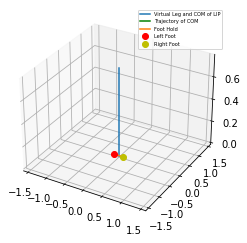

In [10]:
h_fig = plt.figure()
ax = h_fig.add_subplot(111, projection='3d')
h_leg = ax.plot3D(np.array([0, 0]), np.array([0, 0]), np.array([0, Z_ROBOT]), '-', label='Virtual Leg and COM of LIP')
h_com = ax.plot3D(init_robot_pos[0], init_robot_pos[1], init_robot_pos[2], 'g', label='Trajectory of COM')
h_line_foot_hold = ax.plot3D(np.array(foot_pos)[:, 0], np.array(foot_pos)[:, 1], np.array(foot_pos)[:, 2],
                            label='Foot Hold')
h_line_left_foot = ax.plot3D(np.array(foot_pos)[0, 0], np.array(foot_pos)[0, 1], np.array(foot_pos)[0, 2], 'ro',
                            label='Left Foot')
h_line_right_foot = ax.plot3D(np.array(foot_pos)[1, 0], np.array(foot_pos)[1, 1], np.array(foot_pos)[1, 2], 'yo',
                            label='Right Foot')
ax.set_xlim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.set_ylim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.legend(fontsize=5)

In [11]:
class StepInfo():
    def __init__(self, index, state, time_vec, mode, footplant, swing=None):
        self.index = index
        self.state = state
        self.time_vec = time_vec
        self.mode = mode
        self.footplant = footplant
        self.swing = swing
step_infos = []

Move the COM above one foot

In [12]:
walk_ready_points = np.array([[0, 0.67*x0], [0, 0], [Z_ROBOT, Z_MODEL]])
time_points = np.array([0, 1])
time_vec = np.arange(time_points[0], time_points[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(walk_ready_points, time_points, time_vec)
sim_state = SimStates(np.array([]), np.empty((3,1)), np.array([]))

sim_state.time_vec = np.append(sim_state.time_vec, time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q).reshape(3, -1)
sim_state.foot_pos[:] =  np.array([[-X_TORSO], [0], [0]])
sim_state.foot_pos = np.append(sim_state.foot_pos, [[X_TORSO], [0], [0]], 1)

#save data
fhold_x = sim_state.foot_pos[0, 0]
fhold_y = sim_state.foot_pos[1, 0]
body_state = np.array([q[0, :], qd[0, :], q[1, :], qd[1, :], q[2, :], qd[2, :]]).reshape(6, -1)
rel_state = body_state - np.array([fhold_x, 0, fhold_y, 0, 0, 0]).reshape(6, -1)
foot_plant = np.array([fhold_x, fhold_y, 0]).reshape(3, -1)
s1 = StepInfo(1, rel_state, time_vec, 'doublesupport',foot_plant)
step_infos.append(s1)

#for idx in range(sim_state.body_pos.shape[1]):
sim_state.time_vec.shape


(200,)

Make a half step

In [13]:
walk_ready_points = np.append(walk_ready_points, np.array([[0], [0.1], [Z_MODEL]]), 1)
yoff = walk_ready_points[1, 2]
fhold_x = -x0
fhold_y = -y0 + yoff
sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x], [fhold_y], [0]], 1)
way_pts = walk_ready_points[:, 1:3]
vel_pts = np.array([[0, dx0], [0, dy0], [0, 0]])
time_pts = [1, 1.5]
time_vec = np.arange(time_pts[0], time_pts[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(way_pts, time_pts, time_vec, vel_pts)
sim_state.time_vec = np.append(sim_state.time_vec, time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q, 1)

swing_foot_pos0 = sim_state.foot_pos[:, 0]
swing_foot_pos1 = sim_state.foot_pos[:, 2]

[q_swing, qd_swing, qdd_swing] = get_swing_foot_traj(swing_foot_pos0, swing_foot_pos1,
                                                     SWING_HEIGHT, time_pts[0], time_pts[1], SAMPLE_TIME)

body_state = np.array([q[0, :], qd[0, :], q[1, :], qd[1, :], q[2, :], qd[2, :]]).reshape(6, -1)
rel_state = body_state - np.array([sim_state.foot_pos[0, 1], 0, sim_state.foot_pos[1, 1], 0, 0, 0]).reshape(6, -1)
foot_plant = np.array([sim_state.foot_pos[0, 1], sim_state.foot_pos[1, 1], 0]).reshape(3, -1)
s2 = StepInfo(2, rel_state, time_vec, 'singlesupportright',foot_plant, q_swing)
step_infos.append(s2)


In [14]:
sim_state.time_vec.shape

(300,)

In [15]:
def stance_sim(fhold_x, fhold_y, state0, u0, model_vars, sim_states):
    
    ts = model_vars.sample_time
    Ad = model_vars.Ad
    Bd = model_vars.Bd
    
    init_t = sim_states.time_vec[-1] + ts
    final_t = init_t + model_vars.t_single_support
    time_vec = np.arange(init_t, final_t, ts)
    n_steps = np.size(time_vec)
    states = np.zeros((state0.shape[0], n_steps))
    states[:, 0] = state0.reshape(-1)
    
    for idx in range(n_steps - 1):
        states[:, idx + 1] = np.matmul(Ad, states[:, idx]) + np.matmul(Bd, u0).reshape(-1)
    
    sim_states.time_vec = np.append(sim_states.time_vec, time_vec)
    new_states = np.array([[states[0, 1:]+fhold_x], [states[2, 1:]+fhold_y], model_vars.z_model * np.ones((1, n_steps - 1))])
    new_states = new_states.reshape(3, -1)
    sim_states.body_pos = np.append(sim_states.body_pos, new_states, 1)
    
    return [states, time_vec, sim_states]

def change_leg(state1, sim_states):
    
    xf  = state1[0]
    dxf = state1[1]
    yf  = state1[2]
    dyf = state1[3]
    
    x0 = -xf
    y0 = -yf 
    dx0 = dxf 
    dy0 = dyf
    state0 = np.array([[x0], [dx0], [y0], [dy0]])
    
    fhold_x = sim_states.body_pos[0, -1] - x0
    fhold_y = sim_states.body_pos[1, -1] - y0
    
    return [state0, fhold_x, fhold_y]
    

Make consecutive steps

In [16]:
fhold_x1 = fhold_x
fhold_y1 = fhold_y
for stp in range(num_steps):
    
    fhold_x0 = fhold_x1
    fhold_y0 = fhold_y1
    
    [states, time_vec, sim_state] = stance_sim(fhold_x0, fhold_y0, state0, u0, model_vars, sim_state)
    
    [state0, fhold_x1, fhold_y1] = change_leg(states[:, -1], sim_state)
    sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x1], [fhold_y1], [0]], 1)
    
    [q, qd, qdd] = get_swing_foot_traj(sim_state.foot_pos[:, -3], sim_state.foot_pos[:, -1], SWING_HEIGHT,
                                      time_vec[0], time_vec[-1], SAMPLE_TIME)
    
    index = stp + 3
    z_state = np.array([[Z_MODEL]*states.shape[1], [0]*states.shape[1]])
    body_state = np.append(states, z_state).reshape(6, -1)
    foot_plant = np.array([fhold_x0, fhold_y0, 0]).reshape(3, -1)
    
    if stp % 2 == 0:
        mode = 'singlesupportleft'
    else:
        mode = 'singlesupportright'

    s2 = StepInfo(index, body_state, time_vec, mode, foot_plant, q)
    step_infos.append(s2)

In [17]:
sim_state.time_vec.shape

(1908,)

In [18]:
import pickle

with open('step_infos', 'wb') as step_infos_file:
    pickle.dump(step_infos, step_infos_file)

In [19]:
with open('step_infos', 'rb') as step_infos_file:
    stpinfo = pickle.load(step_infos_file)
    print(stpinfo)

[<__main__.StepInfo object at 0x0000019F0F93F0A0>, <__main__.StepInfo object at 0x0000019F0F910A90>, <__main__.StepInfo object at 0x0000019F0F910AC0>, <__main__.StepInfo object at 0x0000019F0F910B50>, <__main__.StepInfo object at 0x0000019F0F910910>, <__main__.StepInfo object at 0x0000019F0F910940>, <__main__.StepInfo object at 0x0000019F0F910970>, <__main__.StepInfo object at 0x0000019F0F9109A0>]


In [22]:
stpinfo[-1].time_vec


array([8.2  , 8.205, 8.21 , 8.215, 8.22 , 8.225, 8.23 , 8.235, 8.24 ,
       8.245, 8.25 , 8.255, 8.26 , 8.265, 8.27 , 8.275, 8.28 , 8.285,
       8.29 , 8.295, 8.3  , 8.305, 8.31 , 8.315, 8.32 , 8.325, 8.33 ,
       8.335, 8.34 , 8.345, 8.35 , 8.355, 8.36 , 8.365, 8.37 , 8.375,
       8.38 , 8.385, 8.39 , 8.395, 8.4  , 8.405, 8.41 , 8.415, 8.42 ,
       8.425, 8.43 , 8.435, 8.44 , 8.445, 8.45 , 8.455, 8.46 , 8.465,
       8.47 , 8.475, 8.48 , 8.485, 8.49 , 8.495, 8.5  , 8.505, 8.51 ,
       8.515, 8.52 , 8.525, 8.53 , 8.535, 8.54 , 8.545, 8.55 , 8.555,
       8.56 , 8.565, 8.57 , 8.575, 8.58 , 8.585, 8.59 , 8.595, 8.6  ,
       8.605, 8.61 , 8.615, 8.62 , 8.625, 8.63 , 8.635, 8.64 , 8.645,
       8.65 , 8.655, 8.66 , 8.665, 8.67 , 8.675, 8.68 , 8.685, 8.69 ,
       8.695, 8.7  , 8.705, 8.71 , 8.715, 8.72 , 8.725, 8.73 , 8.735,
       8.74 , 8.745, 8.75 , 8.755, 8.76 , 8.765, 8.77 , 8.775, 8.78 ,
       8.785, 8.79 , 8.795, 8.8  , 8.805, 8.81 , 8.815, 8.82 , 8.825,
       8.83 , 8.835,